In [32]:
import os
import math
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
from tqdm.auto import tqdm
import numpy as np

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

IMG_SIZE = 32
CHANNELS = 3
BATCH_SIZE = 64
EPOCHS = 10
LR = 2e-4

DIFFUSION_STEPS = 100
BETA_START = 1e-4
BETA_END = 0.02

BASE_CHANNELS = 64
CLASS_EMB_DIM = 128
TIME_EMB_DIM = 128

OUT_DIR = "ddpm_out_fixed"
os.makedirs(OUT_DIR, exist_ok=True)

Device: cuda


In [21]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*CHANNELS, [0.5]*CHANNELS),
])

dataset = datasets.CIFAR100(root="./data", train=True, download=True, transform=transform)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
classes = dataset.classes
print("Dataset size:", len(dataset), "classes:", len(classes))

Dataset size: 50000 classes: 100


In [22]:
def linear_beta_schedule(timesteps, beta_start=BETA_START, beta_end=BETA_END):
    return torch.linspace(beta_start, beta_end, timesteps)

def timestep_embedding(timesteps, dim):
    """
    Sin/cos embedding like transformers.
    timesteps: tensor (B,)
    returns (B, dim)
    """
    half = dim // 2
    freqs = torch.exp(-math.log(10000) * torch.arange(0, half, dtype=torch.float32) / half).to(timesteps.device)
    args = timesteps.float().unsqueeze(1) * freqs.unsqueeze(0)
    emb = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)
    if dim % 2 == 1:
        emb = F.pad(emb, (0,1))
    return emb

In [23]:
class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim=None, class_emb_dim=None):
        super().__init__()
        self.norm1 = nn.GroupNorm(8, in_ch)
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1)
        self.norm2 = nn.GroupNorm(8, out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1)
        self.skip = nn.Conv2d(in_ch, out_ch, kernel_size=1) if in_ch != out_ch else nn.Identity()

        self.time_proj = nn.Linear(time_emb_dim, out_ch) if time_emb_dim is not None else None
        self.class_proj = nn.Linear(class_emb_dim, out_ch) if class_emb_dim is not None else None

    def forward(self, x, t_emb=None, c_emb=None):
        h = self.norm1(x)
        h = F.silu(h)
        h = self.conv1(h)
        if self.time_proj is not None and t_emb is not None:
            h = h + self.time_proj(t_emb).unsqueeze(-1).unsqueeze(-1)
        if self.class_proj is not None and c_emb is not None:
            h = h + self.class_proj(c_emb).unsqueeze(-1).unsqueeze(-1)
        h = self.norm2(h)
        h = F.silu(h)
        h = self.conv2(h)
        return h + self.skip(x)

class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.op = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=4, stride=2, padding=1),
        )
    def forward(self, x):
        return self.op(x)

class Up(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.op = nn.ConvTranspose2d(in_ch, out_ch, kernel_size=4, stride=2, padding=1)
    def forward(self, x):
        return self.op(x)

In [24]:
class SimpleUNet(nn.Module):
    def __init__(self, in_ch=3, base_ch=BASE_CHANNELS, time_emb_dim=TIME_EMB_DIM, class_emb_dim=CLASS_EMB_DIM, num_classes=100):
        super().__init__()
        self.time_mlp = nn.Sequential(
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.SiLU(),
            nn.Linear(time_emb_dim, time_emb_dim),
        )
        self.class_embed = nn.Embedding(num_classes, class_emb_dim)
        self.init_conv = nn.Conv2d(in_ch, base_ch, kernel_size=3, padding=1)
        self.res1 = ResBlock(base_ch, base_ch, time_emb_dim, class_emb_dim)
        self.down1 = Down(base_ch, base_ch)
        self.res2 = ResBlock(base_ch, base_ch*2, time_emb_dim, class_emb_dim)
        self.down2 = Down(base_ch*2, base_ch*2)
        self.mid1 = ResBlock(base_ch*2, base_ch*2, time_emb_dim, class_emb_dim)
        self.mid2 = ResBlock(base_ch*2, base_ch*2, time_emb_dim, class_emb_dim)
        self.up1 = Up(base_ch*2, base_ch*2)
        self.up_res1 = ResBlock(base_ch*2 + base_ch*2, base_ch*2, time_emb_dim, class_emb_dim)
        self.up2 = Up(base_ch*2, base_ch)
        self.up_res2 = ResBlock(base_ch + base_ch, base_ch, time_emb_dim, class_emb_dim)
        self.out = nn.Sequential(
            nn.GroupNorm(8, base_ch),
            nn.SiLU(),
            nn.Conv2d(base_ch, in_ch, kernel_size=3, padding=1)
        )

    def forward(self, x, t, y):
        """
        x: (B, C, H, W)
        t: (B,) long
        y: (B,) long
        """
        t_emb = timestep_embedding(t, self.time_mlp[0].in_features).to(x.device)
        t_emb = self.time_mlp(t_emb)
        c_emb = self.class_embed(y)

        h0 = self.init_conv(x)
        r1 = self.res1(h0, t_emb, c_emb)
        p1 = self.down1(r1)
        r2 = self.res2(p1, t_emb, c_emb)
        p2 = self.down2(r2)
        m = self.mid1(p2, t_emb, c_emb)
        m = self.mid2(m, t_emb, c_emb)
        u1 = self.up1(m)
        u1 = torch.cat([u1, r2], dim=1)
        u1 = self.up_res1(u1, t_emb, c_emb)
        u2 = self.up2(u1)
        u2 = torch.cat([u2, r1], dim=1)
        u2 = self.up_res2(u2, t_emb, c_emb)

        out = self.out(u2)
        return out


In [25]:
betas = linear_beta_schedule(DIFFUSION_STEPS).to(DEVICE)
alphas = 1.0 - betas
alpha_prod = torch.cumprod(alphas, dim=0)
alpha_prod_prev = F.pad(alpha_prod[:-1], (1,0), value=1.0).to(DEVICE)

def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)
    a_t = alpha_prod[t].view(-1,1,1,1)
    sqrt_a = torch.sqrt(a_t)
    sqrt_1_a = torch.sqrt(1 - a_t)
    return sqrt_a * x_start + sqrt_1_a * noise

def p_losses(denoise_model, x_start, t, y, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)
    x_noisy = q_sample(x_start, t, noise=noise)
    predicted_noise = denoise_model(x_noisy, t, y)
    return F.mse_loss(predicted_noise, noise)

In [26]:
@torch.no_grad()
def p_sample_loop(model, shape, class_label, device=DEVICE, T=DIFFUSION_STEPS):
    b = shape[0]
    img = torch.randn(shape, device=device)
    for i in tqdm(reversed(range(T)), desc="Sampling timesteps", total=T):
        t = torch.full((b,), i, device=device, dtype=torch.long)
        pred_noise = model(img, t, class_label)
        beta_t = betas[i].to(device)
        a_t = alphas[i].to(device)
        a_prod_t = alpha_prod[i].to(device)

        coef1 = 1.0 / torch.sqrt(a_t)
        coef2 = beta_t / torch.sqrt(1 - a_prod_t)
        mean = coef1 * (img - coef2 * pred_noise)

        if i > 0:
            noise = torch.randn_like(img)
            sigma = torch.sqrt(beta_t)
            img = mean + sigma * noise
        else:
            img = mean
    return img

@torch.no_grad()
def sample_class_conditional(model, class_idx, n_samples=16):
    model.eval()
    class_tensor = torch.full((n_samples,), class_idx, dtype=torch.long, device=DEVICE)
    imgs = p_sample_loop(model, (n_samples, CHANNELS, IMG_SIZE, IMG_SIZE), class_tensor)
    imgs = (imgs.clamp(-1,1) + 1) / 2
    return imgs

In [27]:
model = SimpleUNet(in_ch=CHANNELS, base_ch=BASE_CHANNELS, time_emb_dim=TIME_EMB_DIM, class_emb_dim=CLASS_EMB_DIM, num_classes=100).to(DEVICE)
optimizer = optim.AdamW(model.parameters(), lr=LR)
print("Model params (M):", sum(p.numel() for p in model.parameters())/1e6)

Model params (M): 2.427139


In [28]:
global_step = 0
for epoch in range(1, EPOCHS+1):
    model.train()
    pbar = tqdm(loader, desc=f"Epoch {epoch}/{EPOCHS}")
    epoch_loss = 0.0
    for imgs, labels in pbar:
        imgs = imgs.to(DEVICE)
        labels = labels.to(DEVICE)
        b = imgs.size(0)

        t = torch.randint(0, DIFFUSION_STEPS, (b,), device=DEVICE).long()
        loss = p_losses(model, imgs, t, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        pbar.set_postfix({"loss": loss.item()})
        global_step += 1

    avg_loss = epoch_loss / len(loader)
    print(f"\nEpoch {epoch} finished, avg loss: {avg_loss:.6f}")

    # checkpoint
    ckpt = {"model": model.state_dict(), "opt": optimizer.state_dict(), "epoch": epoch}
    torch.save(ckpt, os.path.join(OUT_DIR, f"ddpm_epoch_{epoch}.pt"))

    # sample some classes and save grid
    sample_classes = [0, 10, 20, 30]  # change as desired
    all_samples = []
    for cls in sample_classes:
        imgs_gen = sample_class_conditional(model, cls, n_samples=4)
        all_samples.append(imgs_gen)
    grid = torch.cat(all_samples, dim=0)
    save_image(grid, os.path.join(OUT_DIR, f"samples_epoch_{epoch}.png"), nrow=4)
    print("Saved samples at epoch", epoch)

Epoch 1/10:   0%|          | 0/782 [00:00<?, ?it/s]


Epoch 1 finished, avg loss: 0.176801


Sampling timesteps:   0%|          | 0/100 [00:00<?, ?it/s]

Sampling timesteps:   0%|          | 0/100 [00:00<?, ?it/s]

Sampling timesteps:   0%|          | 0/100 [00:00<?, ?it/s]

Sampling timesteps:   0%|          | 0/100 [00:00<?, ?it/s]

Saved samples at epoch 1


Epoch 2/10:   0%|          | 0/782 [00:00<?, ?it/s]


Epoch 2 finished, avg loss: 0.118577


Sampling timesteps:   0%|          | 0/100 [00:00<?, ?it/s]

Sampling timesteps:   0%|          | 0/100 [00:00<?, ?it/s]

Sampling timesteps:   0%|          | 0/100 [00:00<?, ?it/s]

Sampling timesteps:   0%|          | 0/100 [00:00<?, ?it/s]

Saved samples at epoch 2


Epoch 3/10:   0%|          | 0/782 [00:00<?, ?it/s]


Epoch 3 finished, avg loss: 0.109584


Sampling timesteps:   0%|          | 0/100 [00:00<?, ?it/s]

Sampling timesteps:   0%|          | 0/100 [00:00<?, ?it/s]

Sampling timesteps:   0%|          | 0/100 [00:00<?, ?it/s]

Sampling timesteps:   0%|          | 0/100 [00:00<?, ?it/s]

Saved samples at epoch 3


Epoch 4/10:   0%|          | 0/782 [00:00<?, ?it/s]


Epoch 4 finished, avg loss: 0.106282


Sampling timesteps:   0%|          | 0/100 [00:00<?, ?it/s]

Sampling timesteps:   0%|          | 0/100 [00:00<?, ?it/s]

Sampling timesteps:   0%|          | 0/100 [00:00<?, ?it/s]

Sampling timesteps:   0%|          | 0/100 [00:00<?, ?it/s]

Saved samples at epoch 4


Epoch 5/10:   0%|          | 0/782 [00:00<?, ?it/s]


Epoch 5 finished, avg loss: 0.101802


Sampling timesteps:   0%|          | 0/100 [00:00<?, ?it/s]

Sampling timesteps:   0%|          | 0/100 [00:00<?, ?it/s]

Sampling timesteps:   0%|          | 0/100 [00:00<?, ?it/s]

Sampling timesteps:   0%|          | 0/100 [00:00<?, ?it/s]

Saved samples at epoch 5


Epoch 6/10:   0%|          | 0/782 [00:00<?, ?it/s]


Epoch 6 finished, avg loss: 0.101057


Sampling timesteps:   0%|          | 0/100 [00:00<?, ?it/s]

Sampling timesteps:   0%|          | 0/100 [00:00<?, ?it/s]

Sampling timesteps:   0%|          | 0/100 [00:00<?, ?it/s]

Sampling timesteps:   0%|          | 0/100 [00:00<?, ?it/s]

Saved samples at epoch 6


Epoch 7/10:   0%|          | 0/782 [00:00<?, ?it/s]


Epoch 7 finished, avg loss: 0.099710


Sampling timesteps:   0%|          | 0/100 [00:00<?, ?it/s]

Sampling timesteps:   0%|          | 0/100 [00:00<?, ?it/s]

Sampling timesteps:   0%|          | 0/100 [00:00<?, ?it/s]

Sampling timesteps:   0%|          | 0/100 [00:00<?, ?it/s]

Saved samples at epoch 7


Epoch 8/10:   0%|          | 0/782 [00:00<?, ?it/s]


Epoch 8 finished, avg loss: 0.099118


Sampling timesteps:   0%|          | 0/100 [00:00<?, ?it/s]

Sampling timesteps:   0%|          | 0/100 [00:00<?, ?it/s]

Sampling timesteps:   0%|          | 0/100 [00:00<?, ?it/s]

Sampling timesteps:   0%|          | 0/100 [00:00<?, ?it/s]

Saved samples at epoch 8


Epoch 9/10:   0%|          | 0/782 [00:00<?, ?it/s]


Epoch 9 finished, avg loss: 0.097484


Sampling timesteps:   0%|          | 0/100 [00:00<?, ?it/s]

Sampling timesteps:   0%|          | 0/100 [00:00<?, ?it/s]

Sampling timesteps:   0%|          | 0/100 [00:00<?, ?it/s]

Sampling timesteps:   0%|          | 0/100 [00:00<?, ?it/s]

Saved samples at epoch 9


Epoch 10/10:   0%|          | 0/782 [00:00<?, ?it/s]


Epoch 10 finished, avg loss: 0.097201


Sampling timesteps:   0%|          | 0/100 [00:00<?, ?it/s]

Sampling timesteps:   0%|          | 0/100 [00:00<?, ?it/s]

Sampling timesteps:   0%|          | 0/100 [01:40<?, ?it/s]

Sampling timesteps:   0%|          | 0/100 [00:00<?, ?it/s]

Saved samples at epoch 10


Sampling timesteps:   0%|          | 0/100 [00:00<?, ?it/s]

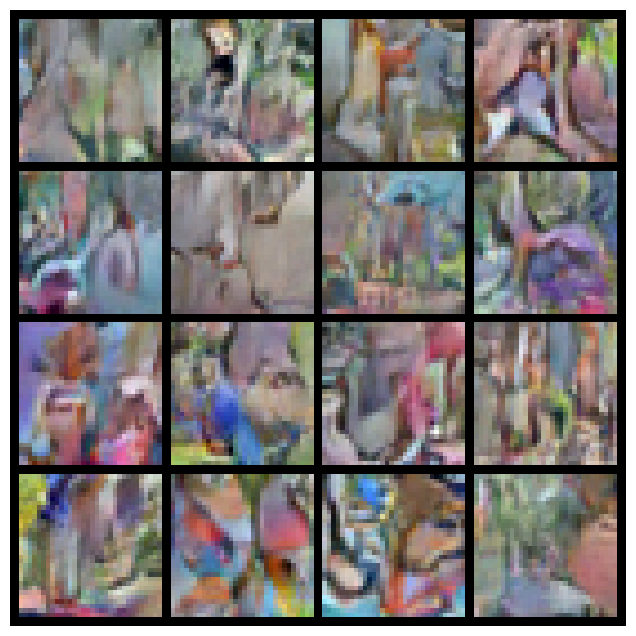

In [49]:
class_idx = 2
imgs = sample_class_conditional(model, class_idx, n_samples=16)
save_image(imgs, os.path.join(OUT_DIR, f"final_samples_class_{class_idx}.png"), nrow=4)
imgs_grid = make_grid(imgs, nrow=4)
np_img = imgs_grid.permute(1, 2, 0).cpu().numpy()

plt.figure(figsize=(8,8))
plt.imshow(np_img)
plt.axis("off")
plt.show()